In [1]:
import zstandard as zstd
import io
import json
import torch as t
import einops
from nnsight import LanguageModel

import sys
sys.path.append('../')
from loading_utils import load_submodule_and_dictionary, DictionaryCfg

/home/can/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = LanguageModel('EleutherAI/pythia-70m-deduped', device_map='cuda:0')

dictionary_dir = "/share/projects/dictionary_circuits/autoencoders/pythia-70m-deduped"
dictionary_size = 32768
submodule, dictionary = load_submodule_and_dictionary(
    model, 
    submod_name='model.gpt_neox.layers.5.mlp.dense_4h_to_h',
    dict_cfg=DictionaryCfg(dictionary_dir, dictionary_size)
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
# set up data as a generator
data_path = '/share/data/datasets/pile/the-eye.eu/public/AI/pile/train/00.jsonl.zst'
compressed_file = open(data_path, 'rb')
dctx = zstd.ZstdDecompressor()
reader = dctx.stream_reader(compressed_file)
text_stream = io.TextIOWrapper(reader, encoding='utf-8')

def generator():
    for line in text_stream:
        yield json.loads(line)['text']
data = generator()

def text_batch(batch_size):
        """
        Return a list of text
        """
        return [
            next(data) for _ in range(batch_size)
        ]

def tokenized_batch(model, ctx_len, batch_size):
        """
        Return a batch of tokenized inputs.
        """
        texts = text_batch(batch_size=batch_size)
        return model.tokenizer(
            texts,
            return_tensors='pt',
            max_length=ctx_len,
            padding=True,
            truncation=True
        )

In [4]:
len_tokenized_prompt = 100

prompt_str = next(data)
prompt_tokid = model.tokenizer.encode(prompt_str, return_tensors='pt')[:, :len_tokenized_prompt]

prompt_prefix = prompt_tokid[:, :-1]
prompt_final_tok = prompt_tokid[:, -1:]

print(f'shape of prompt_tokid: {prompt_prefix.shape}')
print(f'prompt:\n{model.tokenizer.decode(prompt_tokid[0])}')

shape of prompt_tokid: torch.Size([1, 99])
prompt:
It is done, and submitted. You can play “Survival of the Tastiest” on Android, and on the web. Playing on the web works, but you have to simulate multi-touch for table moving and that can be a bit confusing.

There’s a lot I’d like to talk about. I’ll go through every topic, insted of making the typical what went right/wrong list.

Concept

Working over the theme was probably


In [5]:
# Define metric as final token logit
def metric_fn(model):
    logits = model.embed_out.output
    batch_size = logits.shape[0]
    return logits[t.arange(batch_size), -1, prompt_final_tok]

## Feature Gradients

In [9]:
# Cache the gradients of the correct logit w.r.t dictionary features 

with model.invoke(prompt_prefix, fwd_args={'inference' : False}) as invoker:
    # Cache feature activations
    x = submodule.output
    f_act = dictionary.encode(x)
    f_grad = f_act.grad.save()

    # Cache feature gradients
    x_hat = dictionary.decode(f_act)
    residual = (x - x_hat).detach()
    submodule.output = x_hat + residual
    metric_clean = metric_fn(model).save()
metric_clean.value.sum().backward()

print(f'feature_act.shape: {f_act.value}')
print(f'feature_act.grad.shape:')
print(f_grad.value)

/home/can/.local/lib/python3.8/site-packages/nnsight/util.py:48: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  object = getattr(object, atom)


ValueError: Accessing Proxy value before it's been set.

In [49]:
# Error reproduction

# def metric_fn(model):
#     logits = model.embed_out.output
#     batch_size = logits.shape[0]
#     return logits[t.arange(batch_size), -1, prompt_final_tok]

# with model.invoke('Hello World', fwd_args={'inference' : False}) as invoker:
#     x = submodule.output
#     x.retain_grad()
#     x_clean = x.save()
#     metric_clean = metric_fn(model).save()
# metric_clean.value.sum().backward()

# print(f'metric_clean: {metric_clean.value}')
# print(f'x_clean: {x_clean.value}')
# print(f'x_clean.grad:')
# print(x_clean.grad.value)

## Feature activations

In [50]:
text_batch_size = 64
ctx_len = 64
prompt_batch_tokid = tokenized_batch(model, ctx_len, text_batch_size)['input_ids']

prompt_batch_prefix = prompt_batch_tokid[:, :-1]
prompt_batch_final_tok = prompt_batch_tokid[:, -1:]

In [51]:
# Define metric as final token logit
def metric_final_token_logit_batch(model):
    logits = model.embed_out.output
    batch_size = logits.shape[0]
    return logits[t.arange(batch_size), -1, prompt_batch_final_tok]

In [52]:
with model.invoke(prompt_batch_prefix) as invoker:
    mlp_act = submodule.output
    f_act = dictionary.encode(mlp_act).save()

f_act.shape

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([64, 63, 32768])

In [53]:
feat_vecs = einops.rearrange(f_act.value, 'b p d -> (b p) d').to('cpu').detach().numpy()
feat_vecs.shape

(4032, 32768)

### Cosine sim

In [54]:
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

# Normalize feature vectors
norm = normalize(feat_vecs, axis=1, norm='l2')

# Similarity matrix
sim = cosine_similarity(norm)  


In [55]:
prompt_list = einops.rearrange(prompt_batch_tokid, 'b p -> (b p)')

In [56]:
k = 10
looking_at = np.random.choice(len(prompt_list), 10)

for i in looking_at:
    print(f'tokenized prompt: {model.tokenizer.decode(prompt_list[i])}')
    indices = np.argpartition(sim[i], -k)[-k:]
    for index in indices:
        print(f'\t{model.tokenizer.decode(prompt_list[index])}')
    print('\n')

tokenized prompt:  to
	

	 to
	13
	 some
	 worst
	  
	 trans
	 got
	Ti
	 to


tokenized prompt: col
	 but
	 b
	We
	 is
	,
	?
	 this
	col
	-
	.


tokenized prompt: Ad
	 every
	 about
	 school
	vent
	 herein
	jamin
	outs
	balanced
	Ad
	,


tokenized prompt:  tissue
	 ultrasound
	 perform
	 sad
	os
	 bone
	

	 tissue
	 thought
	 never
	 K


tokenized prompt:  are
	 for
	 industrial
	

	 environment
	.
	 alcohol
	 are
	ent
	 EPS
	Ps


tokenized prompt:  post
	…
	 will
	 recording
	Ti
	Ex
	.
	 show
	

	 post
	 some


tokenized prompt: .
	 augmented
	 the
	 database
	 script
	 combined
	 a
	 saving
	 reality
	 a
	.


tokenized prompt:  the
	 teaching
	 happening
	 and
	 meeting
	 work
	 the
	 like
	fact
	This
	 The


tokenized prompt: ,
	 hand
	,
	 one
	 Democratic
	 refractory
	 patients
	,
	USE
	 could
	 the


tokenized prompt: pires
	 patients
	 trio
	 tem
	 a
	 and
	 —
	pires
	ES
	 plotting
	 am




### Spectral clustering w/ cosine similarity

In [57]:
# Degree matrix
deg = np.diag(np.sum(sim, axis=1))

# Graph Laplacian
lap = deg - sim

# Eigen decomposition  
w, v = np.linalg.eigh(lap)

# Extract second smallest eigenvector    
eigenvector = v[:, 1]  

# kMeans clustering
kmeans = KMeans(n_clusters=50, random_state=0)
kmeans.fit(eigenvector.reshape(-1,1)) 

print(kmeans.labels_)

[11 47 47 ... 11 39 11]


/home/can/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [58]:
np.unique(kmeans.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       dtype=int32),
 array([  69,   11,    2,  705,    1,    1,   44,    1,   47,    1,    2,
        1244,    1,   29,    1,    1,    2,   15,  230,   35,   32,    1,
           1,  114,   20,    1,    1,   28,   20,    1,   29,   93,  478,
           4,   47,   78,   35,  153,    1,  142,    1,    1,   35,   61,
           1,    3,   33,  159,    7,   10]))

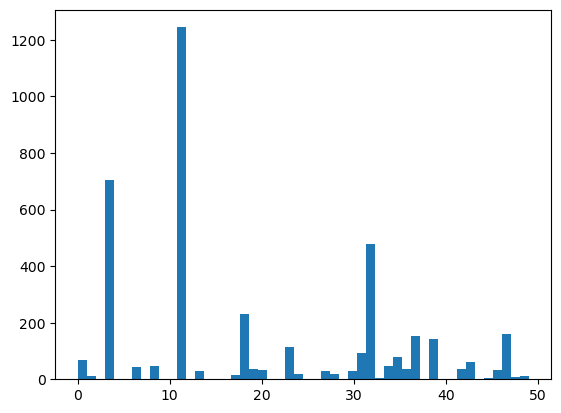

In [62]:
import matplotlib.pyplot as plt
plt.hist(kmeans.labels_, bins=50);

In [70]:
cluster_idx = 35

for idx, lbl in enumerate(kmeans.labels_):
    if lbl == cluster_idx:
        print(model.tokenizer.decode(prompt_list[idx]))

<
 our


 of
 and
 was


}


 list
 While
 de
ú
ación
 the
 movement
 role
el
 comfortably
 body
 in
.
,
 standard
 Here
 properties
 pain


.
 learned
,
 always
 python
 environment
 are
 pregnancy
)
 of
 phosphate
 of
 according
prints
r
 and
 defending
 new
(
,
ter
 map
 benefit
 formed
 Indian
 Brothers


426
 probably
 and
 in
Today
 could
 vol
 the
...
aks
ord
Rog


 controllers
 P
 em
ro
 read
 St
 how
 I
 news
's


### tSNE